In [23]:
! pip install -qU langgraph

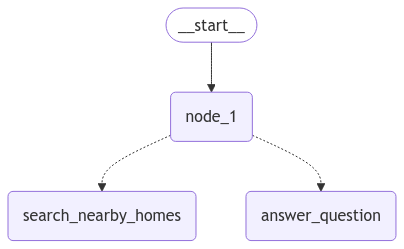

In [28]:
import random
from typing import Optional
from langgraph.graph import START, END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from IPython.display import display,Image
from typing_extensions import Literal,TypedDict
from langgraph.types import Command
from langchain_core.messages import AIMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    address:str
    user_data:Optional[dict]
    

def node_1(state:State)-> Command[Literal["search_nearby_homes", "answer_question"]]:
    print ("--- Node 1 ---")
    value = random.choice(["search_nearby_homes", "answer_question"])
    
    if value == "search_nearby_homes":
        goto='search_nearby_homes'
    else:
        goto='answer_question'  
    return Command(goto=goto)

def search_nearby_homes(state:State):
    print ("--- search_nearby_homes ---")
    pass
def answer_question(state:State):
    print ("--- Answer Questions ---")
    pass

builder:StateGraph = StateGraph(State)

builder.add_edge(START,"node_1")
builder.add_node("node_1",node_1)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)




graph:CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [9]:
graph.invoke({"address":"Karachi"})

--- Node 1 ---
--- Answer Questions ---


{'address': 'Karachi'}

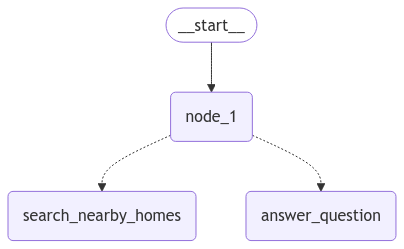

In [34]:
def node_1(state:State)-> Command[Literal["search_nearby_homes", "answer_question"]]:
    print ("--- Node 1 ---")
    value = random.choice(["search_nearby_homes", "answer_question"])
    fetched_userData = {"name":"Ali"}
    
    if value == "search_nearby_homes":
        goto='search_nearby_homes'
    else:
        goto='answer_question'  
        
    return Command(update={"user_data":fetched_userData},goto=goto)

def search_nearby_homes(state:State):
    print ("--- search_nearby_homes ---")
    pass
def answer_question(state:State):
    print ("--- Answer Questions ---")
    pass

builder:StateGraph = StateGraph(State)

builder.add_edge(START,"node_1")
builder.add_node("node_1",node_1)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)




graph:CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
graph.invoke({"address":"Lahore"})

Called A
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}
Called answer_question
UserInfo {'name': 'Ammen Alam'}


{'address': 'Lahore',
 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}],
 'messages': [AIMessage(content='Hi, Ammen Alam Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='20860e5d-05f7-468e-9b44-da51d3b3dbaa')],
 'user_data': {'name': 'Ammen Alam'}}

### Run Nodes(Agents) in Parallel

In [32]:
# Define graph state
from typing import Annotated

class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this
     

# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A")

    # Get User Data From Memory or Data Store
    fetched_user_data = {"name": "Ammen Alam"}

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"user_data": fetched_user_data},
        # this is a replacement for an edge
        goto=["search_nearby_homes", "answer_question"],
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name} Welcome to Homes AI Search Engine")]}
     

builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()
     

agent_response = graph.invoke({"address": "Karachi"})

Called A
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}
Called answer_question
UserInfo {'name': 'Ammen Alam'}
